In [24]:
import networkx as nx
import pickle5 as pickle
import pandas as pd
import numpy as np
from copy import deepcopy

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

from ephen_utils import regularization
from ephen_utils import embedding_graph
from ge import DeepWalk
from ephen_utils import metapath2vec
from ephen_utils import gcn

from sklearn.neighbors import NearestNeighbors

In [2]:
target = 375777
network = '#1'
with open(f"/media/pauloricardo/basement/projeto/graphs/graph_{target}.gpickle", "rb") as fh:
    G = pickle.load(fh)

# regularization
G_regularization = regularization(deepcopy(G))

# deepwalk
model_deep_walk = DeepWalk(deepcopy(G),walk_length=10,num_walks=80,workers=1)
model_deep_walk.train(window_size=5,iter=3,embed_size=512)# train model
embeddings_deep_walk = model_deep_walk.get_embeddings()# get embedding vectors
G_deepwalk = embedding_graph(deepcopy(G), embeddings_deep_walk)

# metapath2vec
user_metapaths = [
    ['event','date','event'],['event','theme','event'],['event','location','event'],
    ['event','person','event'],['event','org','event'],
]
embeddings_metapath2vec = metapath2vec(deepcopy(G), user_metapaths=user_metapaths)
G_metapath2vec = embedding_graph(deepcopy(G), embeddings_metapath2vec)

# gcn
G_gcn = gcn(deepcopy(G), target, 0, 0.2)


Iteration 15 | Energy = 53.065604757306595: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


Learning embedding vectors...
Learning embedding vectors done!
Number of random walks: 805
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



2021-11-17 10:26:18.105921: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-17 10:26:18.138774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 10:26:18.139223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-11-17 10:26:18.139249: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-17 10:26:18.169009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-17 10:26:18.169105: I tensorflow/stream_executor/pl

In [3]:
# colorblind mindful color palette
colors = ['#000000', '#332288', '#882255', '#44AA99', '#C988EE']
sns.set_palette(sns.color_palette(colors))

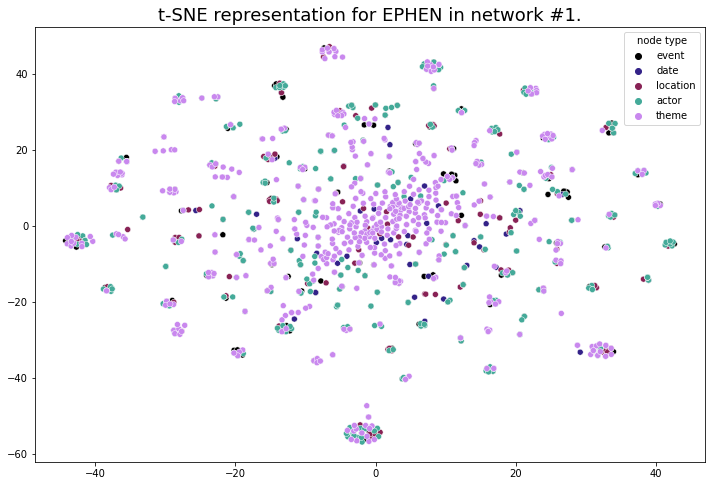

In [15]:
# regularization
nodes = list(G_regularization.nodes())
X, y = [], []
for node in nodes:
    X.append(G_regularization.nodes[node]['f'])
    y.append(G_regularization.nodes[node]['node_type'])

plt.figure(0)
X_embedded = TSNE(n_components=2, perplexity=50.0).fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
df['node type'] = df['node type'].apply(lambda x: 'actor' if x == 'person' or x == 'org' else x)
t = pd.CategoricalDtype(categories=['event','date','location','actor','theme'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for EPHEN in network {network}.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(12,8)
g.get_figure().savefig(f"/media/pauloricardo/basement/projeto/tsne/tsne_regularization_{target}.pdf")

In [88]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'event'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

/home/pauloricardo/anaconda3/envs/masters/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


'Average: 0.937888198757764'

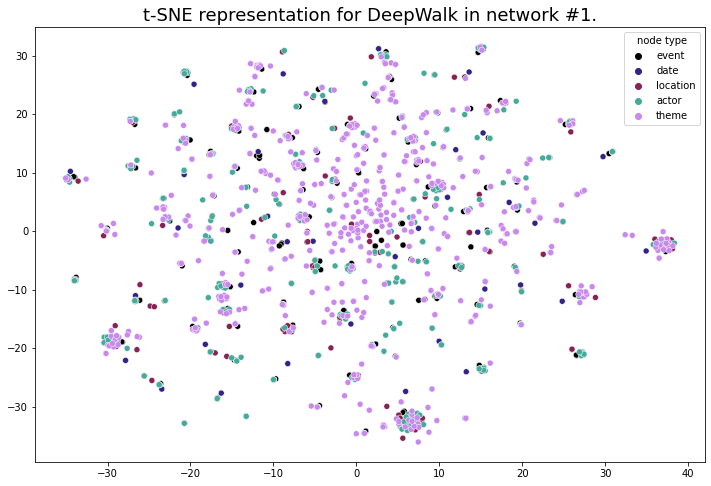

In [89]:
# deepwalk
X, y = [], []
for node in G_deepwalk.nodes():
    X.append(G_deepwalk.nodes[node]['f'])
    y.append(G_deepwalk.nodes[node]['node_type'])

plt.figure(1)
X_embedded = TSNE(n_components=2, perplexity=50.0).fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
df['node type'] = df['node type'].apply(lambda x: 'actor' if x == 'person' or x == 'org' else x)
t = pd.CategoricalDtype(categories=['event','date','location','actor','theme'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for DeepWalk in network {network}.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(12,8)
g.get_figure().savefig(f"/media/pauloricardo/basement/projeto/tsne/tsne_deepwalk_{target}.pdf")

In [90]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'event'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

'Average: 0.8260869565217391'

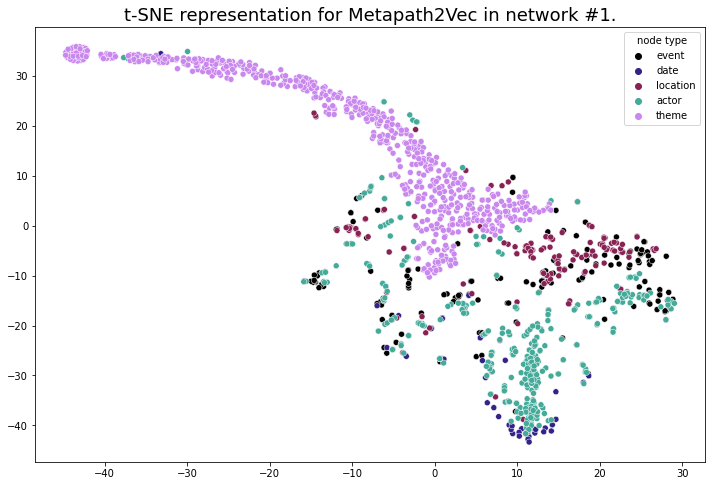

In [91]:
# metapath2vec
X, y = [], []
for node in G_metapath2vec.nodes():
    X.append(G_metapath2vec.nodes[node]['f'])
    y.append(G_metapath2vec.nodes[node]['node_type'])

plt.figure(2)
X_embedded = TSNE(n_components=2, perplexity=50.0).fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
df['node type'] = df['node type'].apply(lambda x: 'actor' if x == 'person' or x == 'org' else x)
t = pd.CategoricalDtype(categories=['event','date','location','actor','theme'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for Metapath2Vec in network {network}.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(12,8)
g.get_figure().savefig(f"/media/pauloricardo/basement/projeto/tsne/tsne_metapath2vec_{target}.pdf")

In [92]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'event'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

'Average: 0.2670807453416149'

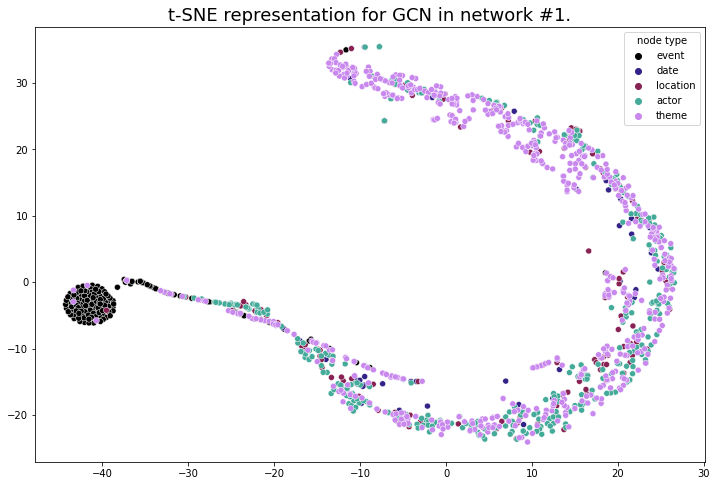

In [93]:
# gcn
X, y = [], []
for node in G_gcn.nodes():
    X.append(G_gcn.nodes[node]['f'])
    y.append(G_gcn.nodes[node]['node_type'])

plt.figure(3)
X_embedded = TSNE(n_components=2, perplexity=50.0).fit_transform(X)

df = pd.DataFrame(X_embedded)
df['node type'] = y
df['node type'] = df['node type'].apply(lambda x: 'actor' if x == 'person' or x == 'org' else x)
t = pd.CategoricalDtype(categories=['event','date','location','actor','theme'], ordered=True)
df['node type'] = pd.Series(df['node type'], dtype=t)
df.sort_values(by=['node type'],inplace=True)
df = df.dropna()

g = sns.scatterplot(x=0, y=1, data=df, hue="node type", legend=True)
g.set_title("\n".join(wrap(f't-SNE representation for GCN in network {network}.')), fontsize=18)
g.set(xlabel=None)
g.set(ylabel=None)

g.get_figure().set_size_inches(12,8)
g.get_figure().savefig(f"/media/pauloricardo/basement/projeto/tsne/tsne_gcn_{target}.pdf")

In [94]:
# 1-nn to test representation
df.sort_index(inplace=True)
nodes_df = pd.DataFrame(nodes)
nodes_df[1] = df['node type']
nodes_df[2] = list(df[[0,1]].to_numpy())
events_df = nodes_df[nodes_df[1] == 'event'].reset_index(drop=True)

knn = NearestNeighbors(n_neighbors=2)
knn.fit(nodes_df[2].to_list())
indexes = knn.kneighbors(events_df[2].to_list(), return_distance=False)

neighbors = []
for index in indexes:
    neighbors.append(nodes_df[0].iloc[index[1]])
events_df[3] = neighbors

wrong_nns = events_df[events_df.apply(lambda x: x[0] == x[3], axis=1)]
for index, row in wrong_nns.iterrows():
    events_df[3].iloc[index] = nodes_df[0].iloc[indexes[index][0]]

events_df[4] = events_df.apply(lambda x: 1 if x[3] in G[x[0]] else 0, axis=1)

f'Average: {events_df[4].mean()}'

/home/pauloricardo/anaconda3/envs/masters/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


'Average: 0.062111801242236024'